In [1]:
# Импорт библиотек
import torch
import torchvision
import copy
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import time
from collections import Counter
import timm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision import models
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from torch.amp import autocast, GradScaler


class AddNoise(object):
    def __init__(self, noise_level):
        self.noise_level = noise_level

    def __call__(self, img):
        img_tensor = transforms.functional.to_tensor(img)
        noise = torch.rand_like(img_tensor) * self.noise_level
        noisy_img = torch.clamp(img_tensor + noise, 0, 1)
        return noisy_img

SIZE = 224
COLOR_DEVIATION = 0.01
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=SIZE),
        AddNoise(0.01),
        transforms.ColorJitter(
            brightness=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            contrast=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            saturation=(1.0-COLOR_DEVIATION, 1.0+COLOR_DEVIATION),
            hue=(-COLOR_DEVIATION, COLOR_DEVIATION)
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

root = 'eyepac-light-v2-512-jpg/'
train_directory = root + 'train'
test_directory = root + 'test'
validation_directory = root + 'validation'

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'validation': datasets.ImageFolder(root=validation_directory, transform=image_transforms['validation']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

train_data_size = len(data['train'])
validation_data_size = len(data['validation'])
test_data_size = len(data['test'])

batch_size = 4

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Train class distribution:", Counter(data['train'].targets))
print("Validation class distribution:", Counter(data['validation'].targets))
print("Test class distribution:", Counter(data['test'].targets))

# Устройство
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

d:\PROJECTS\Diploma\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train class distribution: Counter({0: 4000, 1: 4000})
Validation class distribution: Counter({0: 385, 1: 385})
Test class distribution: Counter({1: 385, 0: 365})
cuda:0


In [14]:
# Определение моделей
def get_model(model_name: str):
    match model_name:
        case "mobilenetv3-large":
            model_ft = models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.DEFAULT, progress=True)
            model_ft.classifier[-1] = nn.Linear(1280, 2)
        case "mobilenetv3-small":
            model_ft = models.mobilenet_v3_small(weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT, progress=True)
            model_ft.classifier[-1] = nn.Linear(1024, 2)
        case "efficientnet-b0":
            model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[-1] = nn.Linear(1280, 2)
        case "resnet18":
            model_ft = models.resnet18(weights='IMAGENET1K_V1', progress=True)
            model_ft.fc = nn.Linear(512, 2)
        case "efficientnet-b3":
            model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[-1] = nn.Linear(1536, 2)
        case "squeezenet":
            model_ft = models.squeezenet1_0(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
            model_ft.num_classes = 2
        case "densenet121":
            model_ft = models.densenet121(weights='IMAGENET1K_V1', progress=True)
            model_ft.classifier = nn.Linear(1024, 2)
        case "vit-tiny":
            model_ft = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
        case "convnext-tiny":
            model_ft = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
        case _:
            raise ValueError(f"Unknown model: {model_name}")
    return model_ft

# Загрузка чекпоинта
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint from {checkpoint_path}, resuming from epoch {start_epoch}")
        return start_epoch, best_acc
    else:
        print(f"No checkpoint found at {checkpoint_path}, starting from scratch")
        return 0, 0.0

# Функция обучения
def train_model(model, criterion, optimizer, scheduler, num_epochs=20, checkpoint_path=None):
    scaler = GradScaler('cuda')
    start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
    train_metrics = []
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(start_epoch, num_epochs):
        epoch_progress = tqdm(total=len(train_data), desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=False)

        for phase in ['train', 'validation']:
            running_loss = 0.0
            running_corrects = 0
            all_labels, all_preds = [], []

            model.train() if phase == 'train' else model.eval()
            dataloader = train_data if phase == 'train' else validation_data

            try:
                for inputs, labels in dataloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        with autocast('cuda'):
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                        if phase == 'train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data).item()

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                    epoch_progress.set_postfix(phase=phase, 
                                              loss=running_loss/len(data[phase]), 
                                              acc=running_corrects/len(data[phase]))
                    epoch_progress.update()

            except RuntimeError as e:
                print(f"CUDA error during {phase}: {e}")
                torch.cuda.empty_cache()
                raise

            epoch_loss = running_loss / len(data[phase])
            epoch_acc = running_corrects / len(data[phase])
            epoch_f1 = f1_score(all_labels, all_preds, average='binary')
            epoch_auc = roc_auc_score(all_labels, all_preds)
            epoch_precision = precision_score(all_labels, all_preds, average='binary')
            epoch_recall = recall_score(all_labels, all_preds, average='binary')
            epoch_vram = torch.cuda.memory_allocated() / 1024**2
            
            if phase == 'train':
                scheduler.step(epoch_acc)

            train_metrics.append({
                'Phase': phase,
                'Epoch': epoch,
                'Loss': epoch_loss,
                'Acc': epoch_acc,
                'F1': epoch_f1,
                'AUC': epoch_auc,
                'Precision': epoch_precision,
                'Recall': epoch_recall,
                'VRAM': epoch_vram
            })

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_progress.close()

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc
        }, checkpoint_path)

    model.load_state_dict(best_model_wts)
    model.eval()
    test_corrects = 0
    all_labels, all_preds = [], []

    for inputs, labels in test_data:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            with autocast('cuda'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data).item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    test_acc = test_corrects / test_data_size
    test_f1 = f1_score(all_labels, all_preds, average='binary')
    test_auc = roc_auc_score(all_labels, all_preds)
    print(f'Test Accuracy: {test_acc:.4f} F1: {test_f1:.4f} AUC: {test_auc:.4f}')

    return model, train_metrics, {'Test_Accuracy': test_acc, 'Test_F1': test_f1, 'Test_AUC': test_auc}

In [16]:
models_names = ["mobilenetv3-large", "mobilenetv3-small", "efficientnet-b0", "resnet18",
                "efficientnet-b3", "squeezenet", "densenet121", "vit-tiny", "convnext-tiny"]
results = pd.DataFrame(columns=['Model', 'Test_Accuracy', 'Test_F1', 'Test_AUC', 'Parameters', 'Training_Time', 'Peak_VRAM_MB', 'Speed'])


model_name = "squeezenet"
print(f'\nTraining {model_name}')
start_time = time.time()

# Настройка batch_size
batch_size = 1 if model_name in ["efficientnet-b3", "vit-tiny", "convnext-tiny", "densenet121"] else 2
train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

# Загрузка модели
model_ft = get_model(model_name).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003 if model_name in ["efficientnet-b3", "vit-tiny", "convnext-tiny", "densenet121"] else 0.001)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', factor=0.1, patience=2)

# Загрузка весов
weights_path = f'{model_name}_weights.pth'
if os.path.exists(weights_path):
    state_dict = torch.load(weights_path, weights_only=False)
    model_ft.load_state_dict(state_dict)
    print(f"Loaded weights from {weights_path}")

checkpoint_path = f'{model_name}_checkpoint.pth'
total_params = sum(p.numel() for p in model_ft.parameters())
print(f"Total number of parameters: {total_params}")

# Обучение
torch.cuda.reset_peak_memory_stats()
try:
    model_ft, train_metrics, test_metrics = train_model(
        model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=11, checkpoint_path=checkpoint_path
    )
except RuntimeError as e:
    print(f"Training failed for {model_name}: {e}")

# Измерение скорости
model_ft.eval()
speed_start = time.time()
with torch.no_grad():
    for inputs, _ in test_data:
        inputs = inputs.to(device)
        model_ft(inputs)
speed = len(data['test']) / (time.time() - speed_start)

# Сохранение результатов
training_time = time.time() - start_time
peak_vram = torch.cuda.max_memory_allocated() / 1024**2
train_results = pd.DataFrame(data=train_metrics)
train_results.to_csv(f"{model_name}_train_metrics.csv", index=False)

results = pd.concat([results, pd.DataFrame([{
    'Model': model_name,
    'Test_Accuracy': test_metrics['Test_Accuracy'],
    'Test_F1': test_metrics['Test_F1'],
    'Test_AUC': test_metrics['Test_AUC'],
    'Parameters': total_params,
    'Training_Time': training_time,
    'Peak_VRAM_MB': peak_vram,
    'Speed': speed
}])], ignore_index=True)

print("\nModel Comparison:")
print(results.sort_values(by='Test_F1', ascending=False))


Training squeezenet
Total number of parameters: 736450
Loaded checkpoint from squeezenet_checkpoint.pth, resuming from epoch 10


Epoch 11/11: 100%|█████████▉| 3999/4000 [04:12<00:00, 16.89it/s, acc=0.5, loss=0.693, phase=train]     d:\PROJECTS\Diploma\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 11/11: 4005it [04:12, 21.20it/s, acc=0.0156, loss=0.0108, phase=validation]                          

train Loss: 0.6934 Acc: 0.5000 F1: 0.0000 AUC: 0.5000


Epoch 11/11: 4384it [04:27, 24.57it/s, acc=0.5, loss=0.693, phase=validation]    d:\PROJECTS\Diploma\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


validation Loss: 0.6934 Acc: 0.5000 F1: 0.0000 AUC: 0.5000
Test Accuracy: 0.4867 F1: 0.0000 AUC: 0.5000

Model Comparison:
        Model  Test_Accuracy  Test_F1  Test_AUC Parameters  Training_Time  \
0  squeezenet       0.486667      0.0       0.5     736450     277.120767   

   Peak_VRAM_MB       Speed  
0    350.196289  169.945459  


C:\Users\litvi\AppData\Local\Temp\ipykernel_10776\1062034057.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{


In [7]:
torch.save(model_ft.state_dict(), weights_path)
results.to_csv('model_comparison.csv', index=False) 

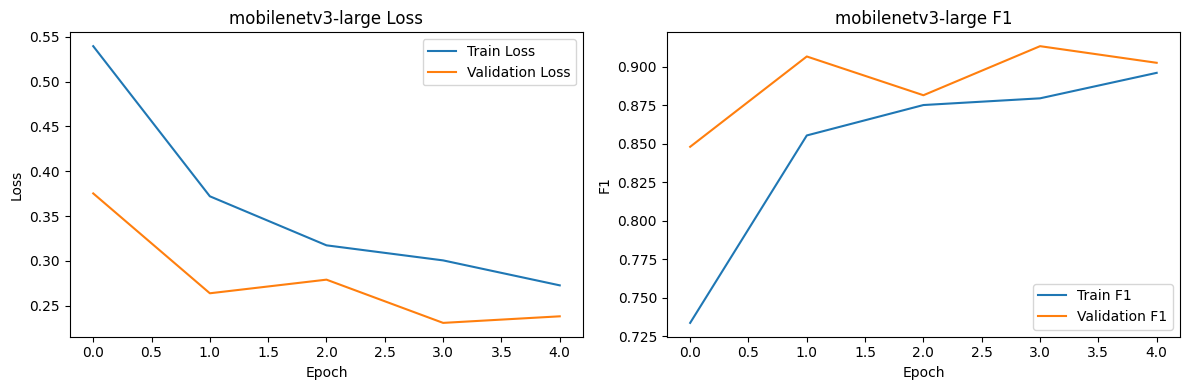

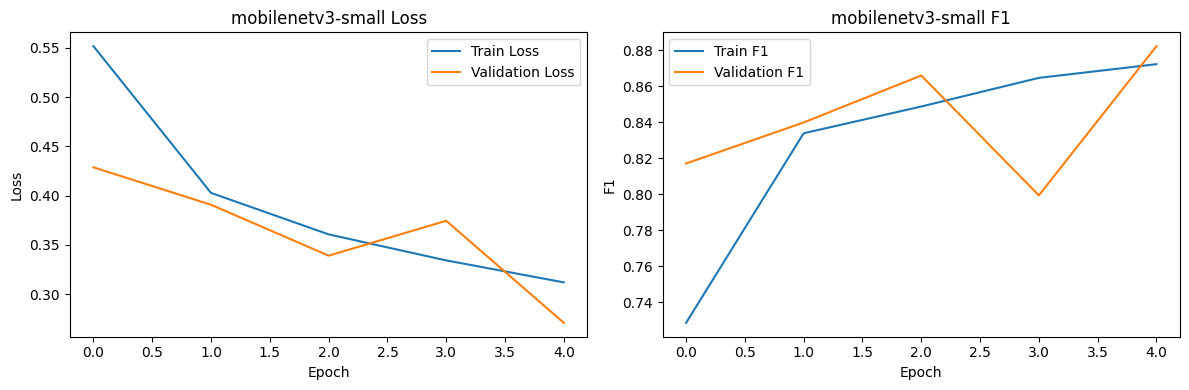

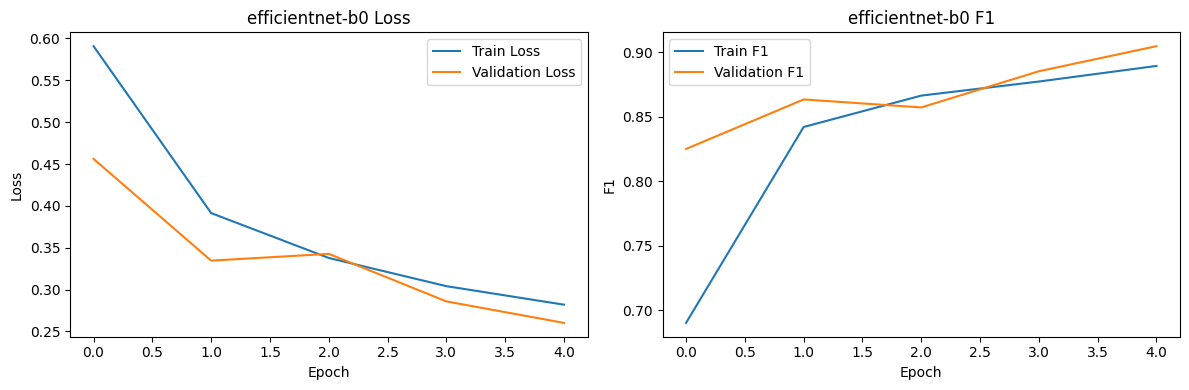

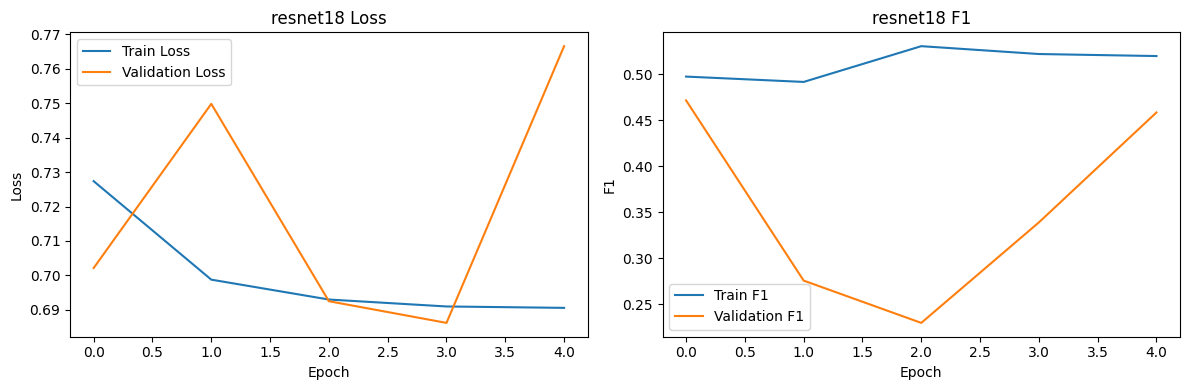

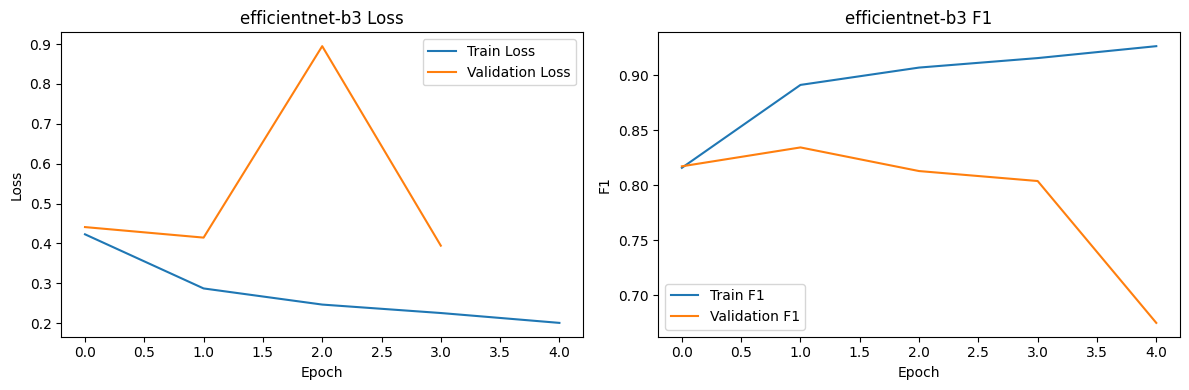

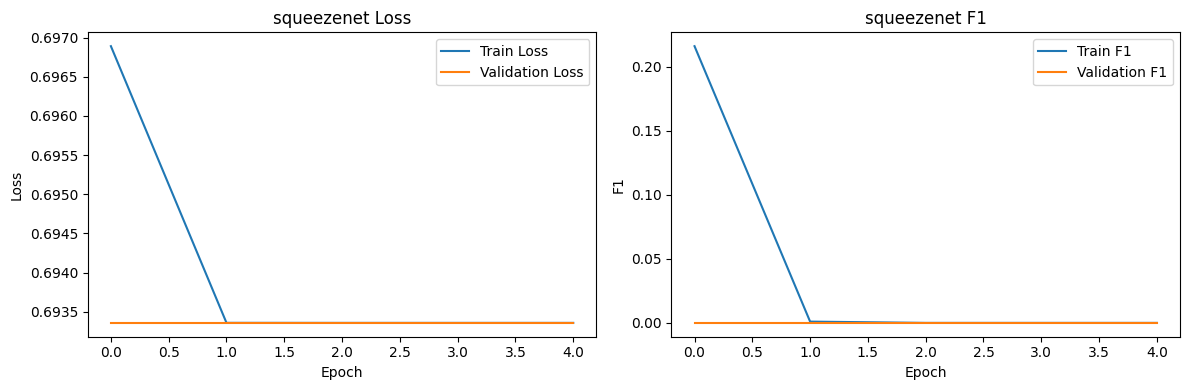

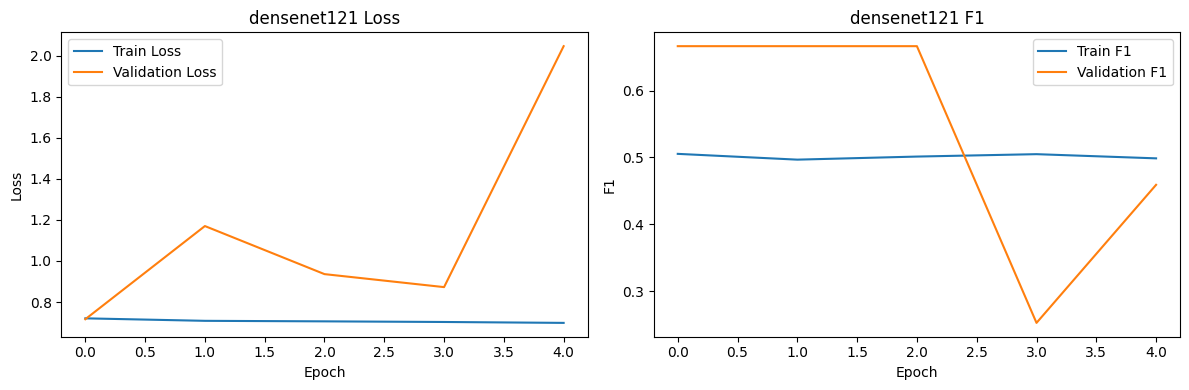

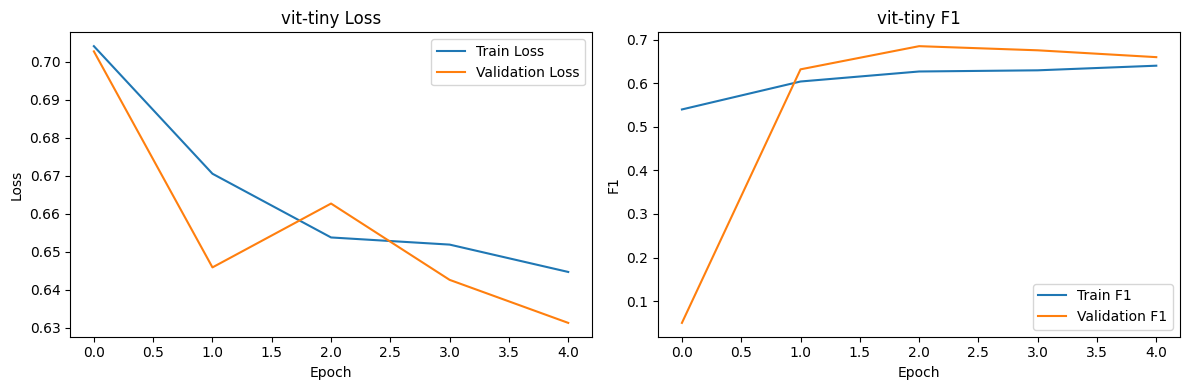

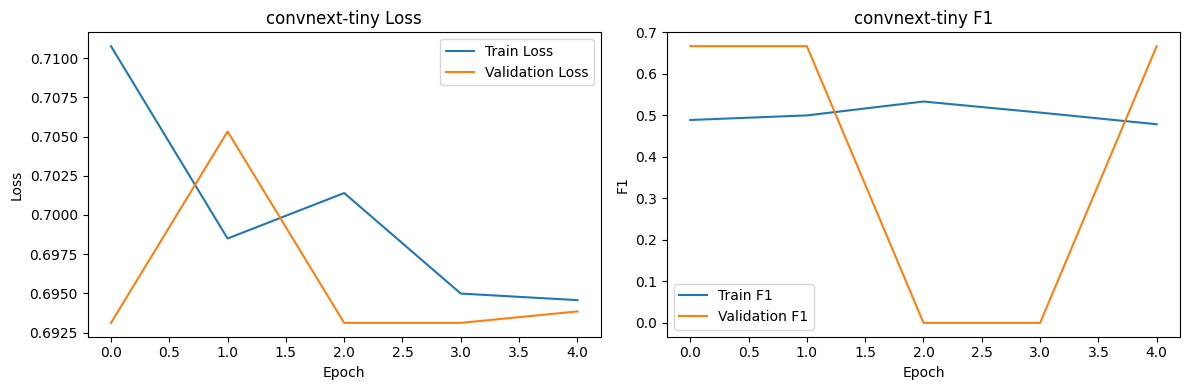

In [9]:
# Визуализация метрик
import matplotlib.pyplot as plt

for model_name in models_names:
    df = pd.read_csv(f"{model_name}_train_metrics.csv")
    train_df = df[df['Phase'] == 'train']
    val_df = df[df['Phase'] == 'validation']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_df['Epoch'], train_df['Loss'], label='Train Loss')
    plt.plot(val_df['Epoch'], val_df['Loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_df['Epoch'], train_df['F1'], label='Train F1')
    plt.plot(val_df['Epoch'], val_df['F1'], label='Validation F1')
    plt.title(f'{model_name} F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()

    plt.tight_layout()
    plt.show()